## Seq2Seq의 Encoder로 뉴스기사 토픽 예측

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## 도입전 기본 처리

In [6]:
# 데이터 불러오기
reuters = keras.datasets.reuters
(train_text, train_topic), (test_text, test_topic) = reuters.load_data()

2121728/2110848 [==============================] - 0s 0us/step


In [7]:
# 데이터 크기 출력
print(train_text.shape)
print(train_topic.shape)
print(test_text.shape)
print(test_topic.shape)

(8982,)
(8982,)
(2246,)
(2246,)


In [8]:
# 데이터 타입 출력
print(train_text.dtype, test_text.dtype)
print(train_topic.dtype, test_topic.dtype)

object object
int64 int64


<BarContainer object of 8982 artists>

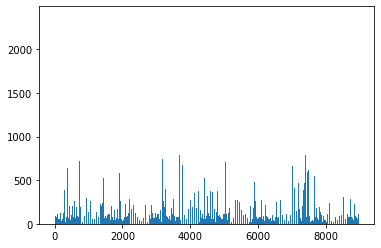

In [9]:
#train_text에서 각 원소의 길이를 y축으로 bar plot 그리기
plt.bar(range(len(train_text)), [len(text) for text in train_text])

## 전처리

In [10]:
# train_text, test_text에서 등장한 정수 알아보기
all_words = set([word for text in train_text for word in text]) | set([word for text in test_text for word in text])

In [11]:
print(sorted(all_words)[:5])
print(sorted(all_words)[-5:])

[1, 2, 4, 5, 6]
[30977, 30978, 30979, 30980, 30981]


In [12]:
# train_text와 test_text를 BOW형태로 변경
train_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_text, value = 0)
test_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_text, value = 0)

In [13]:
(train_bow_text.shape, test_bow_text.shape)

((8982, 2376), (2246, 1032))

In [14]:
# train과 test에 나온 word의 count 측정
import collections
word_count = collections.Counter()
for text in train_text:
    word_count.update(text)
for text in test_text:
    word_count.update(text)

word_count.most_common(10)

[(4, 82723),
 (5, 42393),
 (6, 40350),
 (7, 33157),
 (8, 29978),
 (9, 29956),
 (10, 29581),
 (11, 20141),
 (12, 16668),
 (13, 15224)]

In [15]:
# word_count를 이용해서 n번 이하로 나온 word를 삭제하여 train, test 구성
def cut_by_count(texts, n):
    return np.array([[word for word in text if word_count[word] >= n] for text in texts])

In [16]:
train_cut_text = cut_by_count(train_text, 20)
test_cut_text = cut_by_count(test_text, 20)

In [17]:
train_cut_text.shape, test_cut_text.shape

((8982,), (2246,))

In [19]:
# bow 형태로 변환 후 width 확인
train_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_cut_text, value=0)
test_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_cut_text, value=0)

In [20]:
train_cut_bow_text.shape, test_cut_bow_text.shape

((8982, 2266), (2246, 995))

In [22]:
# train_text/test_text에 길이 제한을 주고 bow를 생성
train_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(train_text, value=0, maxlen=200)
test_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(test_text, value=0, maxlen=200)

In [23]:
train_cut_bow_text2.shape, test_cut_bow_text2.shape

((8982, 200), (2246, 200))

In [24]:
# topic을 onehot encoding으로 변경
np.unique(train_topic)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

In [25]:
train_onehot_topic = keras.utils.to_categorical(train_topic)
test_onehot_topic = keras.utils.to_categorical(test_topic)

In [26]:
train_onehot_topic.shape, test_onehot_topic.shape

((8982, 46), (2246, 46))

In [27]:
# topic 인덱스를 text label로 변환하는 함수 만들기
raw_labels = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

def topic2label(idx):
    return raw_labels[idx]

In [28]:
print(topic2label(0))
print(topic2label(45))

cocoa
lead


## 3. 시각화 방법

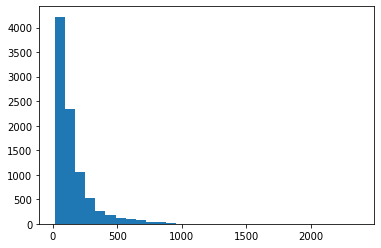

In [29]:
# train_bow_text의 길이 분포 출력
plt.hist([len(s) for s in train_text], bins=30)
plt.show()

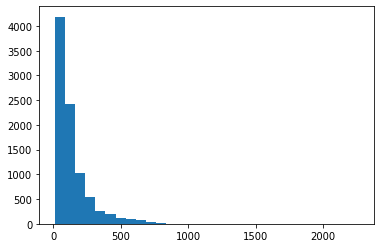

In [30]:
# train_cut_text의 길이 분포 출력
plt.hist([len(s) for s in train_cut_text], bins=30)
plt.show()

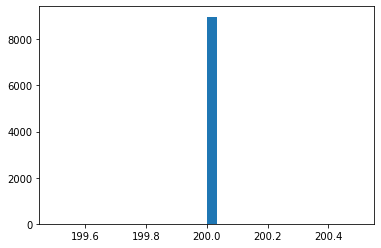

In [31]:
# train_cut_bow_text2의 길이 분포를 출력
plt.hist([len(s) for s in train_cut_bow_text2], bins=30)
plt.show()

In [32]:
train_cut_bow_text2.shape

(8982, 200)

<BarContainer object of 46 artists>

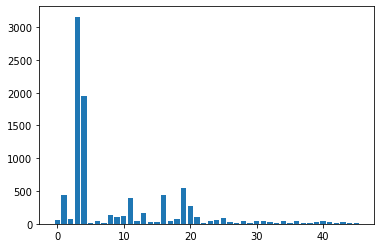

In [33]:
# label 분포 출력
import collections
plt.bar(np.unique(train_topic), list(map(lambda x:x[1], sorted(collections.Counter(train_topic).items()))))

<BarContainer object of 46 artists>

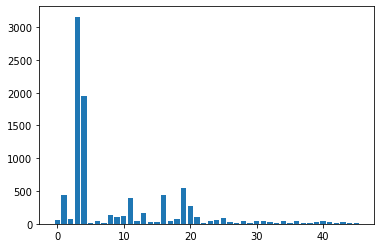

In [34]:
plt.bar(*np.unique(train_topic, return_counts=True))

<AxesSubplot:ylabel='count'>

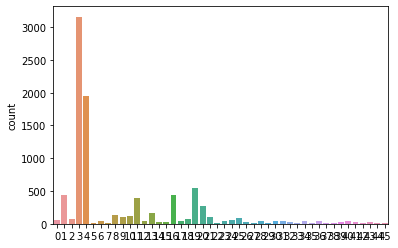

In [35]:
# seaborn 이용 label 분포 출력
sns.countplot(train_topic)

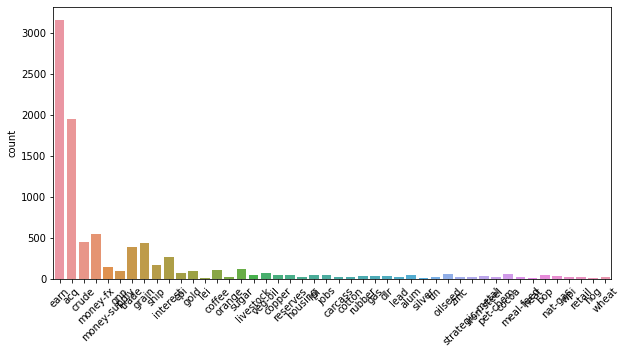

In [36]:
sns.countplot(list(map(lambda x: topic2label(x), train_topic)))
plt.xticks(rotation=45)
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()

In [37]:
# reuters.get_word_index()를 이용, text를 decode
index_word = {y:x for x, y in reuters.get_word_index().items()}

def bow2text(bow):
    return " ".join([index_word[idx] for idx in bow])

bow2text(test_text[1])

565248/550378 [==============================] - 0s 0us/step


"the slide both their a in after london adjusted 2 contracts 54 as sales agriculture with from were vs been prices its for benefit from dlrs vs been are 2 both 97 firms deficient i geneen briefly mln briefly week operating for giving 28 in record disappointed spending shr initiative around five farmers in but 18 66 5 efforts scale will t net mln with deal from billion vs been said in after london adjusted 5 will agip it take supplies briefly mln 9 confidence on been 5 will agriculture method it in has would both administration without on been it intended figures 3 total on been 5 will 75 that in into shares net mln january in three subject for system guaranty deficient users and 381 surviving in attempt 5 higher prices producers without on been 57 request in executive in three it at china concentrate as sales priorities paris said in attempt last told showed 1 and 48 deficit be what briefly mln surviving over qtr prices today is said acres agree in one news possible be 9 1988 vs region

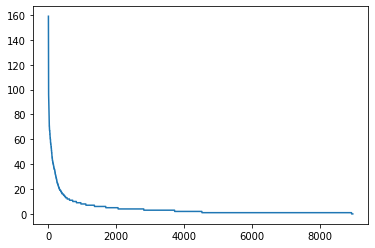

In [38]:
# train/test 데이터에서 문서당 가장 많은 획수로 출현한 word 분포 출력
plt.plot(sorted([np.unique(doc, return_counts=True)[1].argmax() for doc in train_text], reverse=True))

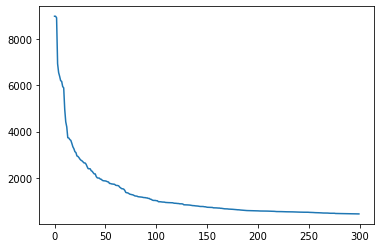

In [39]:
# train/test 전체 문서 당 가장 많이 출현한 word 분포 출력
table = np.zeros(len(all_words)+2)
for doc in train_text:
    table[np.unique(doc)] += 1
plt.plot(sorted(table, reverse=True)[:300])

## 4. Seq2Seq의 Encoder 이용 모델링

In [41]:
# Encoder 이용 분류 모델 구축
# seq2seq 모델 구축 및 학습모델, encoder 획득
from keras.layers import Input, Embedding, GRU, Dense
from keras.models import Model

def Seq2Seq():
    inputs_x_bow = Input(shape=(200,))
    embedding = Embedding(len(index_word)+1, 120)
    x = embedding(inputs_x_bow)  # x = embedding(len(index_word)+1, 120)(inputs_x_bow)
    z = GRU(64)(x)
    y = Dense(46, activation="softmax")(z)

    model = Model(inputs_x_bow, y)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [42]:
# 학습모델 생성 후 summary 출력
model = Seq2Seq()

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 120)          3717600   
                                                                 
 gru (GRU)                   (None, 64)                35712     
                                                                 
 dense (Dense)               (None, 46)                2990      
                                                                 
Total params: 3,756,302
Trainable params: 3,756,302
Non-trainable params: 0
_________________________________________________________________


In [44]:
# 모델 학습
hist = model.fit(
    train_cut_bow_text2,
    train_onehot_topic,
    validation_data = (test_cut_bow_text2, test_onehot_topic),
    verbose = 1,
    epochs = 20
)

Epoch 1/20
281/281 [==============================] - 47s 159ms/step - loss: 2.1884 - accuracy: 0.4105 - val_loss: 1.8111 - val_accuracy: 0.5232
Epoch 2/20
281/281 [==============================] - 48s 172ms/step - loss: 1.6562 - accuracy: 0.5656 - val_loss: 1.7671 - val_accuracy: 0.5623
Epoch 3/20
281/281 [==============================] - 51s 182ms/step - loss: 1.4816 - accuracy: 0.6148 - val_loss: 1.6274 - val_accuracy: 0.6015
Epoch 4/20
281/281 [==============================] - 41s 144ms/step - loss: 1.2632 - accuracy: 0.6648 - val_loss: 1.5406 - val_accuracy: 0.6140
Epoch 5/20
281/281 [==============================] - 33s 117ms/step - loss: 1.0887 - accuracy: 0.7088 - val_loss: 1.5700 - val_accuracy: 0.6091
Epoch 6/20
281/281 [==============================] - 33s 118ms/step - loss: 0.9674 - accuracy: 0.7395 - val_loss: 1.5812 - val_accuracy: 0.6167
Epoch 7/20
281/281 [==============================] - 33s 116ms/step - loss: 0.8494 - accuracy: 0.7742 - val_loss: 1.5877 - val_ac

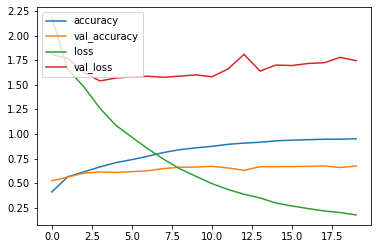

In [45]:
# 학습 진행 상황을 plt로 출력
# hist의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드 작성
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="upper left")
plt.show()

In [46]:
# train_cut_bow_text를 위한 학습 모델 생성, summary 출력
model2 = Seq2Seq()
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 120)          3717600   
                                                                 
 gru_1 (GRU)                 (None, 64)                35712     
                                                                 
 dense_1 (Dense)             (None, 46)                2990      
                                                                 
Total params: 3,756,302
Trainable params: 3,756,302
Non-trainable params: 0
_________________________________________________________________


In [47]:
# 학습모델 학습. train_cut_bow_text의 길이를 200으로 수정 후 실행
train_cut_bow_text.shape, test_cut_bow_text.shape

((8982, 2266), (2246, 995))

In [48]:
hist2 = model2.fit(
    train_cut_bow_text[..., -200:],
    train_onehot_topic,
    validation_data=(test_cut_bow_text[..., -200:], test_onehot_topic),
    verbose=1,
    epochs=20
)

Epoch 1/20
281/281 [==============================] - 53s 180ms/step - loss: 2.1798 - accuracy: 0.4294 - val_loss: 1.7545 - val_accuracy: 0.5445
Epoch 2/20
281/281 [==============================] - 50s 178ms/step - loss: 1.6420 - accuracy: 0.5749 - val_loss: 1.9937 - val_accuracy: 0.4679
Epoch 3/20
281/281 [==============================] - 48s 170ms/step - loss: 1.5115 - accuracy: 0.6118 - val_loss: 1.5835 - val_accuracy: 0.6011
Epoch 4/20
281/281 [==============================] - 48s 171ms/step - loss: 1.3257 - accuracy: 0.6499 - val_loss: 1.5200 - val_accuracy: 0.6082
Epoch 5/20
281/281 [==============================] - 48s 171ms/step - loss: 1.1660 - accuracy: 0.6934 - val_loss: 1.4267 - val_accuracy: 0.6420
Epoch 6/20
281/281 [==============================] - 48s 171ms/step - loss: 1.0109 - accuracy: 0.7483 - val_loss: 1.3866 - val_accuracy: 0.6612
Epoch 7/20
281/281 [==============================] - 48s 173ms/step - loss: 0.8882 - accuracy: 0.7788 - val_loss: 1.4008 - val_ac

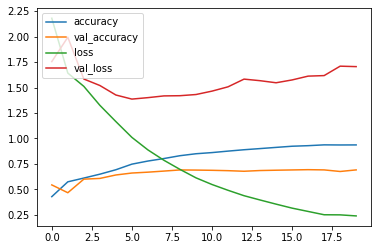

In [49]:
# 학습 진행 상황을 plt로 출력
plt.plot(hist2.history['accuracy'], label='accuracy')
plt.plot(hist2.history['val_accuracy'], label='val_accuracy')
plt.plot(hist2.history['loss'], label='loss')
plt.plot(hist2.history['val_loss'], label='val_loss')
plt.legend(loc="upper left")
plt.show()

## 5. 모델 결과 확인
### 완성된 모델1,2에서 test 하나를 예측하고 결과를 res1, res2 변수에 저장

In [50]:
res1 = model.predict(test_cut_bow_text2[1:2])
res1, res1.shape

(array([[1.3527452e-02, 2.6180947e-01, 1.3665819e-04, 1.2427578e-02,
         6.4181104e-02, 7.6618243e-04, 1.2575616e-07, 1.2242708e-04,
         2.6859659e-06, 4.5897286e-05, 5.7915902e-01, 1.5317921e-05,
         3.9155691e-07, 3.4962017e-02, 2.3655987e-03, 1.4802437e-04,
         6.6998444e-05, 2.0921347e-03, 3.1153856e-08, 5.0158564e-05,
         1.1626141e-05, 3.5004553e-06, 5.5071072e-05, 1.6210448e-02,
         2.4194396e-04, 1.4792494e-05, 7.4780524e-05, 2.2666513e-06,
         6.1390013e-03, 3.5863159e-05, 3.3556203e-06, 1.8316863e-05,
         1.9646759e-04, 1.0179243e-04, 2.8742531e-07, 1.7798482e-04,
         4.8823516e-08, 1.9518590e-04, 3.0705940e-03, 1.2770311e-03,
         2.3893153e-07, 2.8397379e-04, 3.7264140e-06, 1.3346479e-07,
         1.5912599e-07, 2.2191311e-06]], dtype=float32),
 (1, 46))

In [51]:
res2 = model2.predict(test_cut_bow_text[1:2, -200:])
res2, res2.shape

(array([[7.4164225e-03, 2.3323691e-03, 1.9942068e-05, 1.6182944e-03,
         1.1527477e-03, 1.6075101e-03, 2.4939261e-03, 2.2839820e-06,
         2.4690868e-07, 4.0203719e-03, 9.6060574e-01, 1.7506227e-05,
         2.8232569e-07, 3.8376564e-04, 5.8861324e-03, 6.7856209e-04,
         4.2216634e-05, 2.5829891e-04, 2.0767570e-06, 5.0975191e-06,
         4.2995981e-07, 7.0498714e-07, 4.1825828e-05, 1.3986124e-03,
         3.1660376e-05, 3.6615593e-04, 7.6182740e-05, 1.9435056e-05,
         1.4742727e-04, 1.6155216e-05, 4.5664374e-06, 3.4835702e-04,
         3.2243871e-03, 4.2759656e-04, 9.3604058e-06, 2.3945354e-06,
         2.2483125e-06, 2.8571037e-03, 3.0243132e-04, 3.1131236e-05,
         7.3390441e-07, 8.5551816e-04, 1.1367635e-03, 5.0781637e-06,
         1.8568411e-06, 1.4803253e-04]], dtype=float32),
 (1, 46))

'sugar'

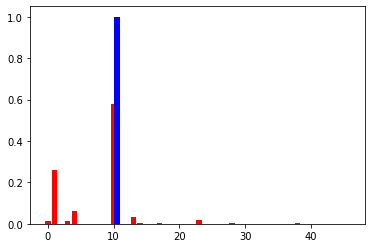

In [52]:
# res1, res2 결과 확인
plt.bar(np.array(range(len(res1[0]))), res1[0], color="red")
plt.bar(np.array(range(len(res1[0]))) + 0.5, test_onehot_topic[1], color="blue")

topic2label(test_onehot_topic[1].argmax())

'sugar'

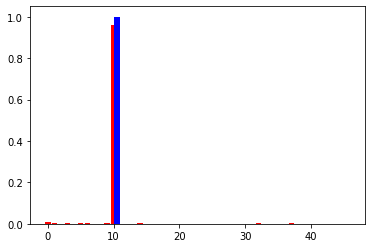

In [53]:
plt.bar(np.array(range(len(res2[0]))), res2[0], color="red")
plt.bar(np.array(range(len(res2[0]))) + 0.5, test_onehot_topic[1], color="blue")

topic2label(test_onehot_topic[1].argmax())

'sugar'

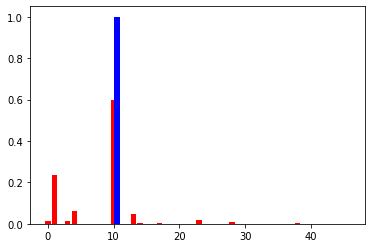

In [54]:
wrong1 = model.predict(test_cut_bow_text[1:2, -200:])

plt.bar( np.array(range(len(wrong1[0]))),  wrong1[0],     color="red" )
plt.bar( np.array(range(len(wrong1[0]))) + 0.5,  test_onehot_topic[1],     color="blue" )

topic2label( test_onehot_topic[1].argmax() ) 

'sugar'

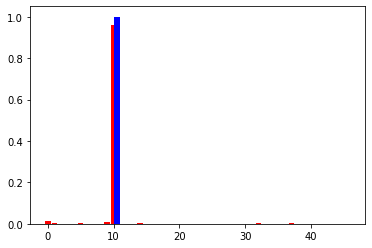

In [55]:
wrong2 = model2.predict(test_cut_bow_text2[1:2])

plt.bar( np.array(range(len(wrong2[0]))),  wrong2[0],     color="red" )
plt.bar( np.array(range(len(wrong2[0]))) + 0.5,  test_onehot_topic[1],     color="blue" )

topic2label( test_onehot_topic[1].argmax() ) 

### reuters.get_word_index()를 이용 평문을 bow로 변환

In [56]:
text = bow2text(test_text[0])
text

'the in wants intermediate 3 how types could mln at against 2 guidelines vs end products opec he will will along results and willingly exports 3 purchased each it stubbornly profit 3 avondale profit agreement in around corp should for 3 cannot mln in ended said avondale a 54 but 3 stubbornly a only generally political primarily date other under well a in british rate gain if demand at an div its taking report montreal systems were is and production had vs 000 7 issued year for 0 a in buffer rate loss may results tariffs dlrs is and from 39 s 000 for 3 cannot pre 50 east that in foods products opec last 1 fall change 1 approval in 15 2 said in opec 28 but for 3 cannot cts systems which is half be 6 iffezheim uobm said president amount pct dlrs'

### text2bow를 이용하여 model1을 통해 결과 확인

In [57]:
def text2bow(text, maxlen = 400):
    word_index = reuters.get_word_index()
    seq = np.array([word_index[word] for word in text.lower().replace("\n", " ").split() if word in word])
    bow = tf.keras.preprocessing.sequence.pad_sequences([seq], value = 0, maxlen = maxlen)
    return bow

In [58]:
bow1 = text2bow(text)
bow1.shape

(1, 400)

In [59]:
bow1

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

<BarContainer object of 46 artists>

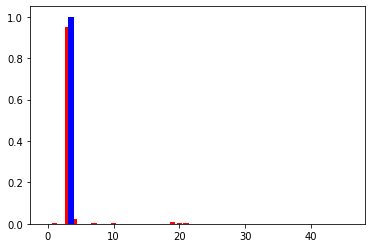

In [60]:
res3 = model.predict(bow1[..., -200:])
plt.bar(np.array(range(len(res3[0]))), res3[0], color="red")
plt.bar(np.array(range(len(res3[0])))+0.5, test_onehot_topic[0], color="blue")

### cut_by_count를 이용, 20회 이상 등장한 word만 사용하는 bow 생성

In [61]:
cut_by_count(bow1, 20)

array([[   1,    4, 1378, 2025,    9,  697, 4622,  111,    8,   25,  109,
          29, 3650,   11,  150,  244,  364,   33,   30,   30, 1398,  333,
           6,  159,    9, 1084,  363,   13,   71,    9,   71,  117,    4,
         225,   78,  206,   10,    9, 1214,    8,    4,  270,    5,    7,
         748,   48,    9,    7,  207, 1451,  966, 1864,  793,   97,  133,
         336,    7,    4,  493,   98,  273,  104,  284,   25,   39,  338,
          22,  905,  220, 3465,  644,   59,   20,    6,  119,   61,   11,
          15,   58,  579,   26,   10,   67,    7,    4,  738,   98,   43,
          88,  333,  722,   12,   20,    6,   19,  746,   35,   15,   10,
           9, 1214,  855,  129,  783,   21,    4, 2280,  244,  364,   51,
          16,  299,  452,   16,  515,    4,   99,   29,    5,    4,  364,
         281,   48,   10,    9, 1214,   23,  644,   47,   20,  324,   27,
          56,    5,  192,  510,   17,   12]])

In [62]:
bow1_cut = tf.keras.preprocessing.sequence.pad_sequences(cut_by_count(bow1, 20), maxlen=200)
bow1_cut

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1,    4, 1378, 2025,
           9,  697, 4622,  111,    8,   25,  109,   29, 3650,   11,  150,
         244,  364,   33,   30,   30, 1398,  333,    6,  159,    9, 1084,
         363,   13,   71,    9,   71,  117,    4,  225,   78,  206,   10,
           9, 1214,    8,    4,  270,    5,    7,  748,   48,    9,    7,
         207, 1451,  966, 1864,  793,   97,  133,  336,    7,    4,  493,
          98,  273,  104,  284,   25,   39,  338,   22,  905,  220, 3465,
         644,   59,   20,    6,  119,   61,   11,   15,   58,  579,   26,
          10,   67,    7,    4,  738, 

### text2bow를 이용, model1 결과 확인

<BarContainer object of 46 artists>

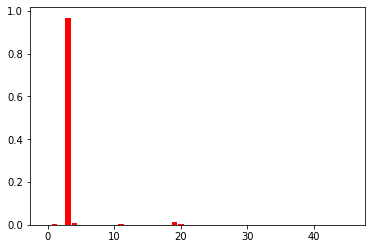

In [63]:
res4 = model2.predict(bow1_cut)
plt.bar(np.array(range(len(res4[0]))), res4[0], color="red")

### confusion 매트릭스 생성

In [64]:
from sklearn.metrics import confusion_matrix

conf_mat1 = confusion_matrix(test_onehot_topic.argmax(axis=1), model.predict(test_cut_bow_text2).argmax(axis=1))
print(conf_mat1), conf_mat1.shape

[[ 7  1  0 ...  0  0  0]
 [ 0 77  1 ...  0  0  0]
 [ 0  1  8 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]


(None, (46, 46))

In [66]:
conf_mat2 = confusion_matrix(test_onehot_topic.argmax(axis=1), model2.predict(test_cut_bow_text2).argmax(axis=1))
print(conf_mat2), conf_mat2.shape

[[ 7  1  0 ...  0  0  0]
 [ 0 77  2 ...  0  0  0]
 [ 0  2  7 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]


(None, (46, 46))

### confusion 매트릭스 가시화

<AxesSubplot:>

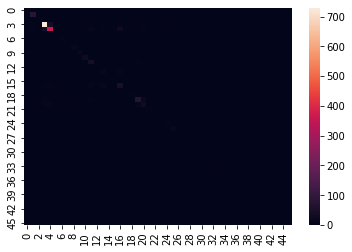

In [67]:
sns.heatmap(conf_mat1)

<AxesSubplot:>

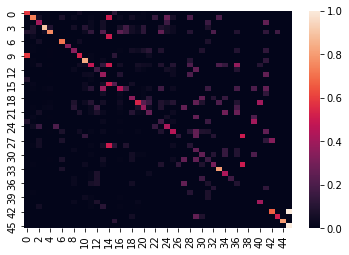

In [68]:
sns.heatmap(conf_mat1 / conf_mat1.sum(axis=1))

<AxesSubplot:>

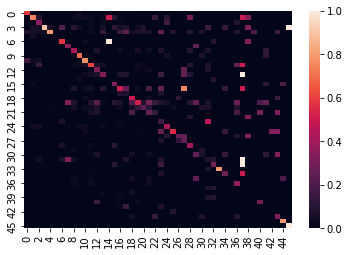

In [69]:
sns.heatmap(conf_mat2 / conf_mat2.sum(axis=1))

### classification 결과 리포팅

In [70]:
from sklearn.metrics import classification_report

print( classification_report(test_onehot_topic.argmax(axis=1), model.predict(test_cut_bow_text2).argmax(axis=1), target_names=raw_labels))

                 precision    recall  f1-score   support

          cocoa       0.41      0.58      0.48        12
          grain       0.67      0.73      0.70       105
        veg-oil       0.44      0.40      0.42        20
           earn       0.91      0.90      0.90       813
            acq       0.80      0.76      0.78       474
          wheat       0.00      0.00      0.00         5
         copper       0.67      0.71      0.69        14
        housing       1.00      0.33      0.50         3
   money-supply       0.46      0.34      0.39        38
         coffee       0.68      0.52      0.59        25
          sugar       0.62      0.83      0.71        30
          trade       0.42      0.48      0.45        83
       reserves       0.22      0.15      0.18        13
           ship       0.22      0.38      0.28        37
         cotton       0.00      0.00      0.00         2
        carcass       0.33      0.22      0.27         9
          crude       0.40    

In [71]:
print( classification_report(test_onehot_topic.argmax(axis=1), model2.predict(test_cut_bow_text[...,-200:]).argmax(axis=1), target_names=raw_labels) )

                 precision    recall  f1-score   support

          cocoa       0.70      0.58      0.64        12
          grain       0.68      0.73      0.71       105
        veg-oil       0.39      0.35      0.37        20
           earn       0.91      0.91      0.91       813
            acq       0.81      0.80      0.80       474
          wheat       0.00      0.00      0.00         5
         copper       0.67      0.57      0.62        14
        housing       0.33      0.33      0.33         3
   money-supply       0.46      0.42      0.44        38
         coffee       0.73      0.64      0.68        25
          sugar       0.66      0.77      0.71        30
          trade       0.56      0.59      0.57        83
       reserves       0.25      0.31      0.28        13
           ship       0.39      0.32      0.35        37
         cotton       0.00      0.00      0.00         2
        carcass       0.29      0.22      0.25         9
          crude       0.39    

## 6. 모델 저장 및 로드, 다운

In [72]:
model.save('./lecture10.h5')

In [73]:
!ls -alh

'ls'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


### 모델 파일을 새로운 모델에 로드

In [74]:
# 모델을 로드하는 코드
new_model = tf.keras.models.load_model('./lecture10.h5')

In [75]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 120)          3717600   
                                                                 
 gru (GRU)                   (None, 64)                35712     
                                                                 
 dense (Dense)               (None, 46)                2990      
                                                                 
Total params: 3,756,302
Trainable params: 3,756,302
Non-trainable params: 0
_________________________________________________________________


### 로드한 모델을 test 데이터로 평가

In [76]:
loss, acc = new_model.evaluate(test_cut_bow_text2, test_onehot_topic, verbose=1)
print(loss, acc)

71/71 [==============================] - 2s 19ms/step - loss: 1.7460 - accuracy: 0.6745
1.7460391521453857 0.6745324730873108
